In [28]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2

from utils import *
from plotting import *
from find_pose import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [29]:
#* load matlab data
matlab_data_qtm = sio.loadmat('QTE_n_cam.mat')
matlab_data_frames = sio.loadmat('frames_1501_1700.mat')
print(matlab_data_qtm.keys())
print(matlab_data_frames.keys())

#! the 5th sensor in qtm_coords is not moving when played the video. appearantly it's the exact camera position...
gt_coords = matlab_data_qtm['QTM_coords'][[0,1,2,3],:,:] 

gt_coords = gt_coords.transpose(2,0,1)# qtm coordinates arranged [num_frames, num_points, 3d]

gt_coords = gt_coords - gt_coords[0,0,:] # subtracting the z coordinate of the first frame to make bootom of yae in origin

camera_mat = matlab_data_qtm['K']

frames_1501_1700 = matlab_data_frames['frames_1501_1700']
frames_1501_1700 = frames_1501_1700.transpose(3,0,1,2) 
# frames arranged [num_frames, height, width, 3 {for rgb}]

markers_cr_1700 = np.float32(matlab_data_frames['col_row_1700'])
markers_cr_1501 = np.float32(matlab_data_frames['col_row_1501'])



# loaded matlab data into tensors

dict_keys(['__header__', '__version__', '__globals__', 'K', 'QTM_coords', 'cameraParams', 'x', 'y', 'z'])
dict_keys(['__header__', '__version__', '__globals__', 'col_row_1501', 'col_row_1700', 'frames_1501_1700'])


### Rigid to easy pose

Text(0.5, 0.92, 'corrected rigid')

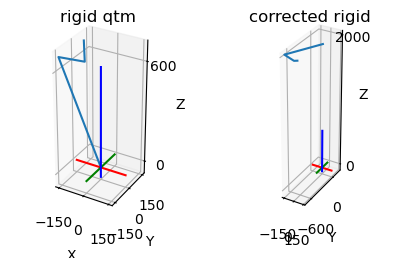

In [30]:
# GET the rigid object to an easier pose

rigid = gt_coords[0]
#* plot the rigid

rig_init_pose = rotate_translate(rigid, angle_axis=np.array([0.0, 0.0, -torch.pi/2]))

rig_init_pose = rotate_translate(rig_init_pose, angle_axis=np.array([torch.pi/2 + torch.pi/50 , 0.0, 0.0]))

rig_init_pose = rotate_translate(rig_init_pose, translation=np.array([0,0,3*rigid[2,2]]))

fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
plot_rigid_3d(rigid, ax=ax0)
ax0.set_title('rigid qtm')
plot_rigid_3d(rig_init_pose, ax=ax1)
ax1.set_title('corrected rigid')

# cv2.solvePnp with P3P.
tried schemes from cv2.solvepnp and this worked best.

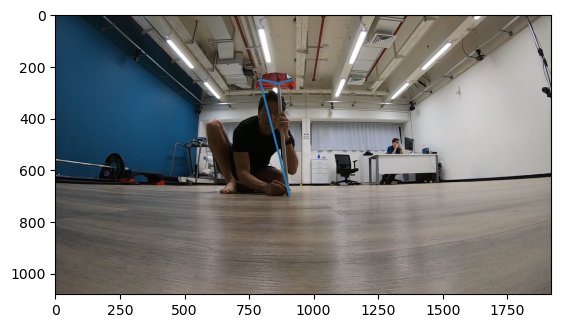

In [9]:
# plot the image with the markers
plot_image_with_points(frames_1501_1700[-1], [markers_cr_1700])

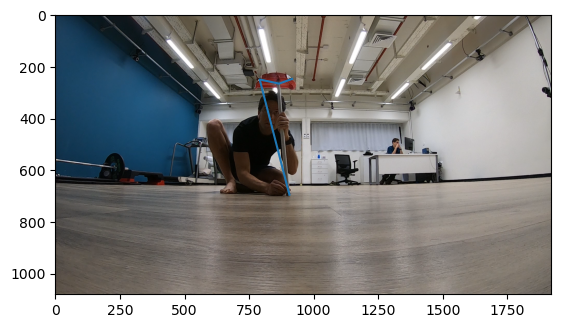

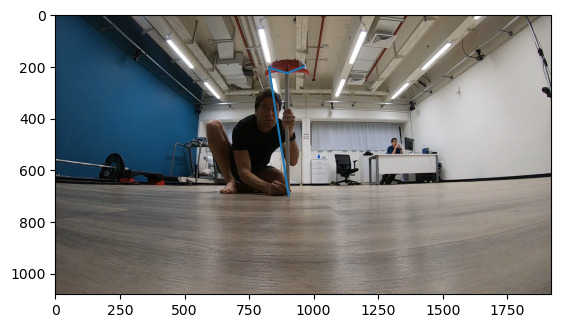

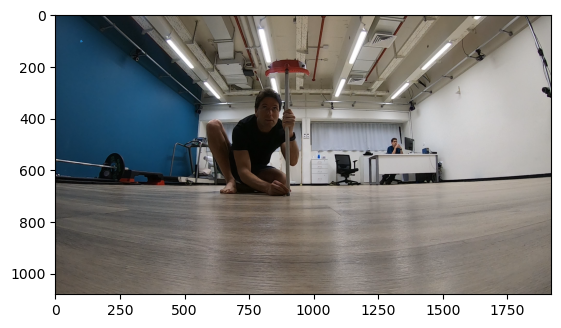

In [31]:
# find the rotation and translation by solving pnp
%matplotlib inline

_,_,_,rotated_translated_1700 = find_pose_rigid_im_pts(rig_init_pose, markers_cr_1700, camera_mat)
rotated_translated_projected_1700 = project_on_camera(rotated_translated_1700, camera_mat)
plot_image_with_points(frames_1501_1700[-1], [rotated_translated_projected_1700])

_,_,_,rotated_translated_1501 = find_pose_rigid_im_pts(rig_init_pose, markers_cr_1501, camera_mat)
rotated_translated_projected_1501 = project_on_camera(rotated_translated_1501, camera_mat)
plot_image_with_points(frames_1501_1700[0], [rotated_translated_projected_1501])




In [27]:
# test that the points that the pnp found have a minimal distance from the points in the image
abs_diff_1501 = np.abs(rotated_translated_projected_1501 - markers_cr_1501)
abs_diff_1700 = np.abs(rotated_translated_projected_1700 - markers_cr_1700)

print(f'abs_diff_1501: {abs_diff_1501.mean()}')
print(f'abs_diff_1700: {abs_diff_1700.mean()}')


abs_diff_1501: 0.10560309031932746
abs_diff_1700: 0.5238927912481657
